# Predicting Rate my Professor Ratings

### Identifying the predictive Task 

**What is our predictive task?**

In this project we will analyze a dataset of user's rate my professor ratings and predict what rating a user will give to a certain professor. Our data set contains 5 features: professor name, review text, rating, difficulty and time/date the review was written.

**How will we evaluate our model?**

To evaluate this model, we will use MSE, MAE, and RMSE for each of our models based on the our predicted labels and the validation set. 

**What are our baselines?**

Relevant baselines to compare to our prediction models to would be a naive model which only predicts the global mean for each professor. We will calculate the global mean of the entire data set (ie.. every rating of every professor) for the baseline prediction.

**How do we know our model is valid?**

To ensure the validity of our model, we will compare the RMSE, MSE, and MAE of our model in comparison to the naive mean prediction to ensure that our model performs better than the baseline. Additionally, we will train the model on a subset of the data set and allocate another portion as our test set to guarantee that our model works for data it has not yet been trained on which is a direct indicator of it's real world performance. 

In [76]:
# !pip install datasets

In [3]:
from datasets import load_dataset

ds = load_dataset("ZephyrUtopia/ratemyprofessors_reviews")

/home/jgamba/anaconda3/envs/CSE158R/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import pandas as pd

df_train = ds["train"].to_pandas()
df_test = ds["test"].to_pandas()

### Exploratory Analysis, Data Collection, Preprocessing, and Discussion

**Dataset**
Our data comes from HuggingFace and was collected through webscraping a total of 480,342 RateMyProfessors reviews. The dataset is split into a training set with 336,239 reviews and a test set with 144,103 reviews. Each data vector contains 5 features:
- Name of instructor
- Review text
- Course rating
- Course difficulty
- Date submitted

In [5]:
df_train['rating'].value_counts()

rating
5.0    179439
1.0     59866
4.0     45200
2.0     26333
3.0     25314
4.5        39
3.5        20
1.5        14
2.5        14
Name: count, dtype: int64

(336239, 5)
(144103, 5)
480342


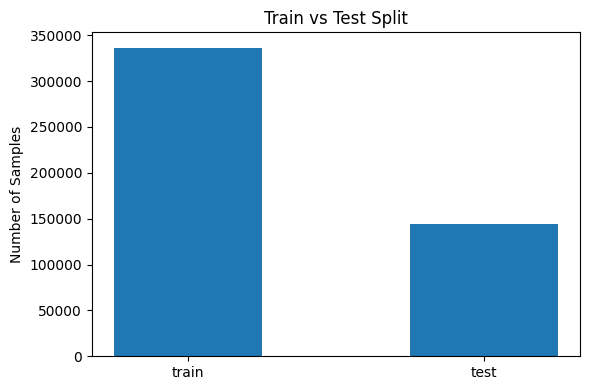

In [7]:
import matplotlib.pyplot as plt
import numpy as np

print(df_train.shape)
print(df_test.shape)
print (df_test.shape[0] + df_train.shape[0])

plt.figure(figsize=(6,4))
plt.bar(["train", "test"], [len(df_train), len(df_test)], width=0.5)
plt.title("Train vs Test Split")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0']


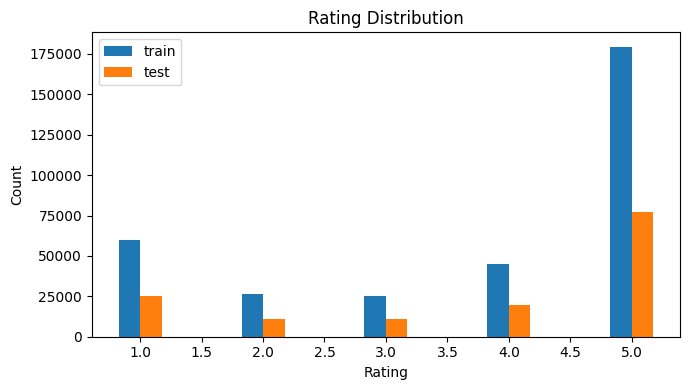

In [8]:
# get unique rating values
train_ratings = df_train['rating']
test_ratings = df_test['rating']
all_ratings = sorted(set(train_ratings).union(test_ratings))
print(all_ratings)

train_counts = df_train["rating"].value_counts().reindex(all_ratings)
test_counts  = df_test["rating"].value_counts().reindex(all_ratings)

x = np.arange(len(all_ratings))
width = 0.35

plt.figure(figsize=(7,4))
# print(train_counts.values)
plt.bar(x - width/2, train_counts.values, width, label="train")
plt.bar(x + width/2, test_counts.values, width, label="test")

plt.xticks(x, all_ratings)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.legend()
plt.tight_layout()
plt.show()


### Modeling

In [9]:
import numpy as np
def MSE(y, ypred):
    y = np.array(y, dtype=float)
    ypred = np.array(ypred, dtype=float)
    return np.mean((y - ypred) ** 2)

def getGlobalAverage(trainRatings):
    # Return the average rating in the training set
    return np.mean(trainRatings)



In [10]:
df_train

,name,text,rating,difficulty,date
0,Leila Hawana,"Although the homework is not too much, they ar...",4.0,5.0,2018-11-01
1,Gloria Magana,Where can I start she's a very tough grader. H...,1.0,5.0,2020-12-15
2,Teresa Canganelli,She is a wonderful professor! Very interactive...,5.0,4.0,2020-02-20
3,Kumar Ankit,Study solutions had incorrect answers taken fr...,1.0,4.0,2018-12-11
4,Irina Garces,Super nice and helpful. Was always there in of...,5.0,4.0,2019-05-15
...,...,...,...,...,...
336234,Ruth Chananie,"Great professor, weekly discussions. Great wri...",5.0,3.0,2021-12-12
336235,Jennifer Baggett,She is an amazing teacher and a great person t...,5.0,2.0,2021-05-20
336236,JoAnn Balingit,Really fun professor! Her class is super inter...,5.0,2.0,2018-10-31
336237,Jacobson Blomquist,This professor holds the textbook and reads ou...,1.0,4.0,2018-12-11


In [11]:
train_ratings = np.array(df_train['rating'], dtype='float')
test_ratings = np.array(df_test['rating'], dtype='float')
print(getGlobalAverage(train_ratings))

3.7674704600001783


In [12]:
print(MSE(train_ratings, getGlobalAverage(train_ratings)))

2.4709575975729883


In [13]:
!pip install scikit-learn

In [14]:
from sklearn.preprocessing import OneHotEncoder

df_train["timestamp"] = pd.to_datetime(df_train["date"])
df_train["year"] = df_train["timestamp"].dt.year
df_train["month"] = df_train["timestamp"].dt.month
df_train["dayofweek"] = df_train["timestamp"].dt.dayofweek
df_train["day"] = df_train["timestamp"].dt.day


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    stop_words="english"
)

In [16]:
from sklearn.compose import ColumnTransformer

X = df_train[["name", "difficulty", "year", "month", "day", "dayofweek", "text"]]
y = df_train["rating"]

preprocess = ColumnTransformer(
    transformers=[
        ("name", OneHotEncoder(handle_unknown="ignore"), ["name"]),
        ("num", "passthrough", ["difficulty", "year", "month", "day", "dayofweek"]),
        ("text", TfidfVectorizer(max_features=5000, stop_words="english"), "text"),
    ]
)

In [17]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", Ridge(alpha=1.0))
])

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('name', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
from sklearn.metrics import mean_squared_error

preds = model.predict(X_test)
preds = np.clip(preds, a_min=1, a_max=5)
mse = mean_squared_error(y_test, preds)
print("MSE:", mse)

MSE: 0.736213946316533


In [20]:
df_test["timestamp"] = pd.to_datetime(df_test["date"])
df_test["year"] = df_test["timestamp"].dt.year
df_test["month"] = df_test["timestamp"].dt.month
df_test["dayofweek"] = df_test["timestamp"].dt.dayofweek
df_test["day"] = df_test["timestamp"].dt.day

In [21]:
X_valid = df_test[["name", "difficulty", "year", "month", "day", "dayofweek", "text"]]
y_valid = df_test["rating"]

preds = model.predict(X_valid)
preds = np.clip(preds, a_min=1, a_max=5)
mse = mean_squared_error(y_valid, preds)
print("MSE:", mse)

MSE: 0.7343462604803729


#### Improvements:

In [22]:
# try changing TF-IDF Params (increase features)

preprocess = ColumnTransformer(
    transformers=[
        ("name", OneHotEncoder(handle_unknown="ignore"), ["name"]),
        ("num", "passthrough", ["difficulty", "year", "month", "day", "dayofweek"]),
        ("text", TfidfVectorizer(max_features=6000, stop_words="english"), "text"),
    ]
)

In [23]:
model2 = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", Ridge(alpha=1.0))
])

In [24]:
model2.fit(X_train, y_train)

preds2 = model2.predict(X_test)
preds2 = np.clip(preds2, a_min=1, a_max=5)
mse2 = mean_squared_error(y_test, preds2)
print("MSE:", mse2)

MSE: 0.7349694046906275


In [25]:
preds2 = model2.predict(X_valid)
preds2 = np.clip(preds2, a_min=1, a_max=5)
mse2 = mean_squared_error(y_valid, preds2)
print("MSE:", mse2)

MSE: 0.731827487825645


In [ ]:
# try changing TF-IDF Params (increase features)
for feature in [10000, 12000, 13000, 14000]:

    preprocess = ColumnTransformer(
        transformers=[
            ("name", OneHotEncoder(handle_unknown="ignore"), ["name"]),
            ("num", "passthrough", ["difficulty", "year", "month", "day", "dayofweek"]),
            ("text", TfidfVectorizer(max_features=feature, stop_words="english"), "text"),
        ]
    )

    model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", Ridge(alpha=1.0))
])
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    preds = np.clip(preds, a_min=1, a_max=5)
    mse3 = mean_squared_error(y_test, preds)
    print("MSE:", mse)

    preds = model.predict(X_valid)
    preds = np.clip(preds, a_min=1, a_max=5)
    mse = mean_squared_error(y_valid, preds)
    print("Valid MSE:", mse)

MSE: 0.729900589366397
Valid MSE: 0.7297859740214411
MSE: 0.7297859740214411
Valid MSE: 0.7299873551168088
MSE: 0.7299873551168088
Valid MSE: 0.7297570390857784
MSE: 0.7297570390857784
Valid MSE: 0.729900589366397


In [ ]:
# No more improvement increasing features

# try increasing n-grams

In [55]:
best_test_mse = 0.729900589366397 # 10000 features
best_valid_mse = 0.7297859740214411
best_range = 0
for num in [2, 3, 4, 5]:
    preprocess = ColumnTransformer(
        transformers=[
            ("name", OneHotEncoder(handle_unknown="ignore"), ["name"]),
            ("num", "passthrough", ["difficulty", "year", "month", "day", "dayofweek"]),
            ("text", TfidfVectorizer(max_features=10000, ngram_range=(1,num), stop_words="english"), "text"),
        ]
    )

    model3 = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", Ridge(alpha=1.0))
    ])

    model3.fit(X_train, y_train)

    preds = model3.predict(X_test)
    preds = np.clip(preds, a_min=1, a_max=5)
    test_mse = mean_squared_error(y_test, preds)
    print(f'{num}-range has mse: {test_mse}')

    preds = model3.predict(X_valid)
    preds = np.clip(preds, a_min=1, a_max=5)
    valid_mse = mean_squared_error(y_valid, preds)
    print(f'{num}-range has valid-mse: {valid_mse}')
    
    if test_mse < best_test_mse and valid_mse < best_valid_mse:
        best_test_mse = test_mse
        best_range = num
        best_valid_mse = valid_mse

print(f'Best valid-mse with {best_range}-gram is {best_valid_mse}')




2-range has mse: 0.6787456734302375
2-range has valid-mse: 0.6764364087348798
3-range has mse: 0.6778043340294698
3-range has valid-mse: 0.6752936308777214
4-range has mse: 0.6779215585867618
4-range has valid-mse: 0.6754429640614894
5-range has mse: 0.6775722741907838
5-range has valid-mse: 0.6753309109827811
Best valid-mse with 3-gram is 0.6752936308777214


In [52]:
# try a different regression model
from sklearn.linear_model import Lasso

preprocess = ColumnTransformer(
        transformers=[
            ("name", OneHotEncoder(handle_unknown="ignore"), ["name"]),
            ("num", "passthrough", ["difficulty", "year", "month", "day", "dayofweek"]),
            ("text", TfidfVectorizer(max_features=10000, ngram_range=(1,3), stop_words="english"), "text"),
        ]
    )

model4 = Pipeline(steps=[
    ('preprocess', preprocess),
    ('regressor', Lasso(alpha=1.0))
])

model4.fit(X_train, y_train)

preds = model4.predict(X_test)
preds = np.clip(preds, a_min=1, a_max=5)
mse = mean_squared_error(y_test, preds)
print("MSE:", mse)

preds = model4.predict(X_valid)
preds = np.clip(preds, a_min=1, a_max=5)
mse = mean_squared_error(y_valid, preds)
print("Valid MSE:", mse)




MSE: 2.462824647497568
Valid MSE: 2.45892669055887


In [57]:
best_alpha = 1
for alpha in range(2,40):
    preprocess = ColumnTransformer(
            transformers=[
                ("name", OneHotEncoder(handle_unknown="ignore"), ["name"]),
                ("num", "passthrough", ["difficulty", "year", "month", "day", "dayofweek"]),
                ("text", TfidfVectorizer(max_features=10000, ngram_range=(1,3), stop_words="english"), "text"),
            ]
        )

    model5 = Pipeline(steps=[
        ("preprocess", preprocess),
        ("regressor", Ridge(alpha=alpha))
        ])

    model5.fit(X_train, y_train)

    preds = model5.predict(X_test)
    preds = np.clip(preds, a_min=1, a_max=5)
    test_mse = mean_squared_error(y_test, preds)
    

    preds = model5.predict(X_valid)
    preds = np.clip(preds, a_min=1, a_max=5)
    valid_mse = mean_squared_error(y_valid, preds)
    
    if test_mse < best_test_mse and valid_mse < best_valid_mse:
        best_valid_mse = valid_mse
        best_test_mse = test_mse
        best_alpha = alpha

print(f'Best alpha is {best_alpha} with a valid mse of {best_valid_mse}')

Best alpha is 4 with a valid mse of 0.6546055573943995


### Evaluation

### Discussion of Related Work